<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import findspark
findspark.init()

import sys
from pyspark import SparkConf, SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import Row, SQLContext

from operator import add
import matplotlib.pyplot as plt

conf = SparkConf()
conf.setAppName("trendings_hashtags")

batch_duration = 10
window_duration = 20

sc = SparkContext(conf=conf)
ssc = StreamingContext(sc, batchDuration)

host = "localhost"
port = 5555
socket_stream = ssc.socketTextStream(host, port)

lines = socket_stream.window(window_duration)

hashtags = lines.flatMap(lambda line: line.split())\
                .filter(lambda word: word.lower().startswith("#"))

pairs = hashtags.map(lambda hashtag: (hashtag, 1))
hashtags_counts = pairs.reduceByKey(add)


def get_sql_context_instance(spark_context):
    if ('sqlContextSingletonInstance' not in globals()):
        globals()['sqlContextSingletonInstance'] = SQLContext(
            spark_context)
    return globals()['sqlContextSingletonInstance']


def rdd_operation(time, rdd):
    try:
        # Get spark sql singleton context from the current context
        sql_context = get_sql_context_instance(rdd.context)
        # convert the RDD to Row RDD
        row_rdd = rdd.map(lambda w: Row(hashtag=w[0], hashtag_count=w[1]))
        # create a DF from the Row RDD
        hashtags_df = sql_context.createDataFrame(row_rdd)
        # Register the dataframe as table
        hashtags_df.registerTempTable("hashtags")
        # get the top 10 hashtags from the table using SQL and print them
        hashtag_counts_df = sql_context.sql(
            "select hashtag, hashtag_count from hashtags order by \
            hashtag_count desc limit 10").toPandas()

        hashtag_counts_df.plot.barh(
            x='hashtag', y='hashtag_count',
            title=str(time), legend=False)
        plt.show()

    except:
        e = sys.exc_info()
        print("Error: {}".format(e))


hashtags_counts.foreachRDD(processRDD)

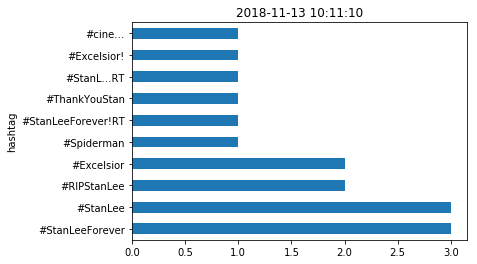

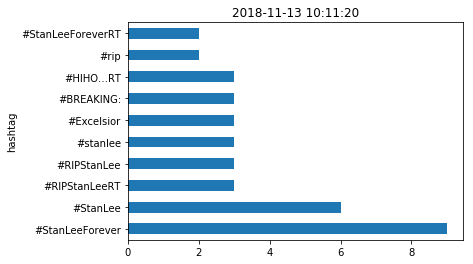

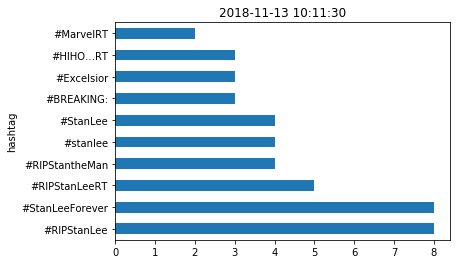

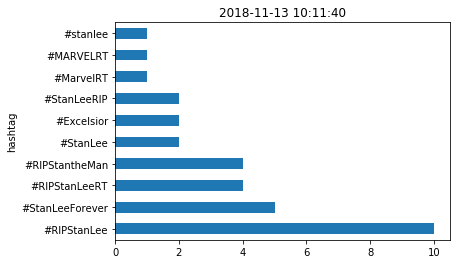

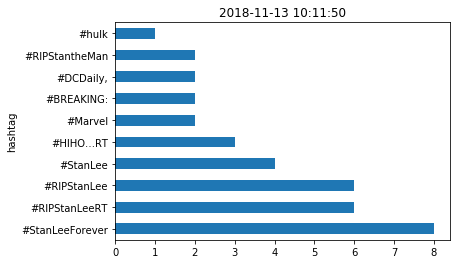

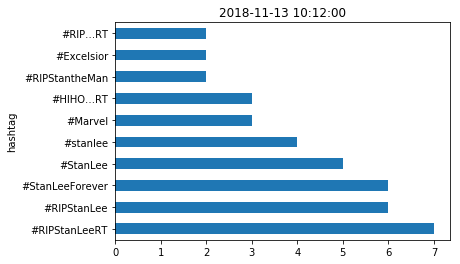

KeyboardInterrupt: 

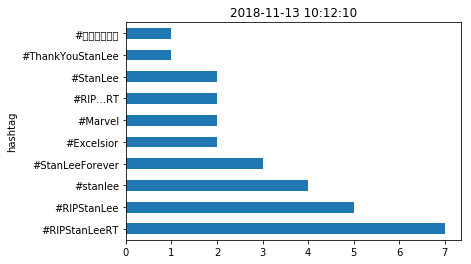

In [2]:
# start streaming
ssc.start()
ssc.awaitTermination()

In [3]:
# close the connection
ssc.stop()